# State Space Models and the Kalman Filter

In this notebook we will introduce the Kalman Filter as an alternative to using linear regression for estimating the hedge ratio. The typical weakness in linear regression to estimate the hedge ratio is that hedge ratio is time varying. Thus, we have two approaches approximating the hedge ratio. The first approach is to use a rolling window estimate and cross validate it on the past to get a hedge ratio as a function of time. A more advanced approach is to use the Kalman Filter as an alternative. In short, the Kalman Filter is using baysian inference to treat the 'true' hedge ratio as an unobserved variable and we approximate it.

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from pykalman import KalmanFilter

In [2]:
def draw_date_coloured_scatterplot(etfs, prices):
    """
    Create a scatterplot of the two ETF prices, which is coloured by the date of the price to indicate the changing relationship
    between the sets of prices
    """
    # Create a yellow-to-red colourmap where yellow indicates
    # early dates and red indicates later dates
    plen= len(prices)
    colour_map = plt.cm.get_cmap('YlOrRd')
    coulours = np.linspace(0.1, 1, plen)
    
    # Create the scatterplot object
    scatterplot = plt.scatter(
        prices[etfs[0]], prices[etfs[1]],
        s=30, c=coulours, cmap=colour_map,
        edgecolor='k', alpha=0.8
    )
    # Add a colour bar for the date colouring and set the
    # corresponding axis tick labels to equal string-formatted dates
    colourbar = plt.colorbar(scatterplot)
    colourbar.ax.set_yticklabels(
        [str(p.date()) for p in prices[::plen//9].index]
    )
    plt.xlabel(prices.columns[0])
    plt.ylabel(prices.columns[1])
    plt.show()

In [3]:
def calc_slope_intercept_kalman(etfs, prices):
    """
    Utilise the Kalman Filter from the PyKalman pakcage to calculate the slope and intercept of the regressesed ETF prices
    """
    delta = 1e-5
    trans_cov = delta / (1-delta) * np.eye(2)
    obs_mat = np.vstack(
        [prices[etfs[0]], np.ones(prices[etfs[0]].shape)]
    ).T[:, np.newaxis]
    
    kf = KalmanFilter(
        n_dim_obs=1,
        n_dim_state=2,
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov
    )
    state_means, state_covs = kf.filter(prices[etfs[1]].values)
    return state_means, state_covs

In [4]:
def draw_slope_intercept_changes(prices, state_means):
    """
    Plot the slope and intercept changes from the Kalman Filter calculated values.
    """
    pd.DataFrame(
        dict(
            slope=state_means[:,0],
            intercept=state_means[:,1]
        ), index=prices.index
    ).plot(subplots=True)
    plt.show()

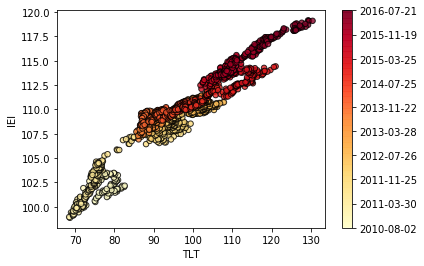

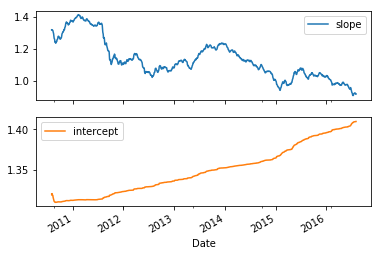

In [6]:
etfs = ['TLT','IEI'] # The treasuries etfs
start_date = "2010-08-01"
end_date = "2016-08-01"

#obtain the adjusted closing prices from yahoo finance
etf_df1 = pdr.get_data_yahoo(etfs[0], start_date, end_date)
etf_df2 = pdr.get_data_yahoo(etfs[1], start_date, end_date)
prices = pd.DataFrame(index=etf_df1.index)
prices[etfs[0]] = etf_df1["Adj Close"]
prices[etfs[1]] = etf_df2["Adj Close"]
draw_date_coloured_scatterplot(etfs, prices)
state_means, state_covs = calc_slope_intercept_kalman(etfs, prices)
draw_slope_intercept_changes(prices, state_means)